In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import pickle
import numpy as np
import lightgbm as lgb

from os import listdir
from os.path import isfile, join

from scipy.stats import entropy
from scipy.special import softmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
from helper import *

from matplotlib import mlab
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [108]:
#base batch_size=500
# time_inference = {
#     'resnet_18' : 0.043308353,
#     'resnet_34' : 0.063735914,
#     'resnet_50' : 0.114385653,
#     'resnet_101' : 0.183127236,
#     'nasnet_mobile' : 0.8923602104187012,
#     'nasnet_large' : 5.196358609199524*2,
#     'pnasnet_mobile' : 0.8181339502334595,
#     'pnasnet_large' : 4.892335391044616*2,    
    
# }
# time_inference_cpu = {
#     'resnet_18' : 1.012381005,
#     'resnet_34' : 1.728078532,
#     'resnet_50' : 2.145581436,
#     'resnet_101' : 3.449709797,
#     'nasnet_mobile' : 0.,
#     'nasnet_large' : 0.,
#     'pnasnet_mobile' : 0.,
#     'pnasnet_large' : 0.,    
# }

#base batch_size=1
time_inference = {
    'resnet_18' : 0.004326963,
    'resnet_34' : 0.007118535,
    'resnet_50' : 0.01020844,
    'resnet_101' : 0.01618433,    
    'nasnet_large' : 0.01995,
    'nasnet_small' : 0.05271,
    'pnasnet_large' : 0.01443,
    'pnasnet_small' : 0.04514
}
time_inference_cpu = {
    'resnet_18' : 0.035453391,
    'resnet_34' : 0.05855341,
    'resnet_50' : 0.074465179,
    'resnet_101' : 0.114496183,    
    'nasnet_mobile' : 0.068,
    'nasnet_large' : 0.408,
    'pnasnet_mobile' : 0.07008,
    'pnasnet_large' : 0.37611
}

In [3]:
resnets = [18, 34, 50, 101]

logits = {}
accuracy_dict = {}

for i in resnets :
    net = 'resnet_' + str(i)
    l, acc = load_logit_acc(net, 'pred_'+str(i))
    print(net, np.mean(acc))
    logits[net] = l
    accuracy_dict[net] = acc

resnet_18 0.6972
resnet_34 0.72984
resnet_50 0.75826
resnet_101 0.77266


In [4]:
y_val_dict = {}
pred_dict = {}

for i in range(len(resnets)-1) :
    net1 = resnets[i]
    for j in range(i+1, len(resnets)) :
        net2 = resnets[j]
        merge_net_name = str(net2) + '_' + str(net1)
        saved_net_name = 'resnet_' + str(net1) + '_resnet_' + str(net2)
        y_pred, y_val = load_probability(merge_net_name)
        auc = roc_auc_score(y_val, y_pred)
        print(saved_net_name, auc)
        
        pred_dict[saved_net_name] = y_pred
        y_val_dict[saved_net_name] = y_val

resnet_18_resnet_34 0.8145272218110744
resnet_18_resnet_50 0.8233510095675672
resnet_18_resnet_101 0.8246405110531924
resnet_34_resnet_50 0.837726432268437
resnet_34_resnet_101 0.8391358313030646
resnet_50_resnet_101 0.8559524972474787


In [5]:
def evaluate(net1, net2, gpu=True) :
    accuracy1 = accuracy_dict[net1]
    accuracy2 = accuracy_dict[net2]
    
    logits1 = logits[net1]
    softmax_val = softmax(logits1, axis=1)
    entropy_val = np.array([entropy(x) for x in softmax_val])

    y_pred = pred_dict[net1 + '_' + net2]
    y_val = y_val_dict[net1 + '_' + net2]
        
    print(net1, np.mean(accuracy1), '+', net2, np.mean(accuracy2))
    return y_pred, y_val, entropy_val, accuracy1, accuracy2

In [140]:
net1 = 'resnet_18'
net2 = 'resnet_50'
y_pred, y_val, entropy_val, accuracy1, accuracy2 = evaluate(net1, net2)
auc_entropy = roc_auc_score(y_val, entropy_val)
auc_boosting = roc_auc_score(y_val, y_pred)
print('AUC entropy', auc_entropy, 'AUC boosting', auc_boosting)   

resnet_18 0.6972 + resnet_50 0.75826
AUC entropy 0.7931397275867154 AUC boosting 0.8233510095675672


In [141]:
t, a, p, v01, v10 = calculate_speedup(entropy_val, accuracy1, accuracy2)
t2, a2, p2, v012, v102 = calculate_speedup(y_pred, accuracy1, accuracy2)

In [142]:
time_small = time_inference_cpu[net1]
time_large = time_inference_cpu[net2]
speedup_cpu = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p])
speedup_cpu2 = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p2])

In [143]:
time_small = time_inference[net1]
time_large = time_inference[net2]
speedup_gpu = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p])
speedup_gpu2 = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p2])

In [144]:
min(a), max(a)

(-0.00047999999999992493, 0.06106)

In [147]:
x = 0.038
idx = np.argmax(speedup_cpu[a<=x])
print('entropy', p[idx])
print('cpu', speedup_cpu[idx], a[idx])
idx = np.argmax(speedup_gpu[a<=x])
print('gpu', speedup_gpu[idx], a[idx])

idx = np.argmax(speedup_cpu2[a2<=x])
print('boosting', p2[idx])
print('cpu', speedup_cpu2[idx], a2[idx])
idx = np.argmax(speedup_gpu2[a2<=x])
print('gpu', speedup_gpu2[idx], a2[idx])

entropy 0.13064
cpu 1.6481334786696025 0.038000000000000034
gpu 1.8034221706208557 0.038000000000000034
boosting 0.10466
cpu 1.7218609971656493 0.037980000000000014
gpu 1.8920712088865084 0.037980000000000014


In [126]:
def show(all_thresholds, all_accuracy, all_speedup, title) :
    thresholds = all_thresholds.reshape(100, -1)
    thresholds = np.hstack((thresholds[:, 0], thresholds[-1, -1]))
    accuracy = all_accuracy.reshape(100, -1)
    accuracy = np.hstack((accuracy[:, 0], accuracy[-1, -1]))
    speedup = all_speedup.reshape(100, -1)
    speedup = np.hstack((speedup[:, 0], speedup[-1, -1]))
    
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax1.set_ylabel('Accuracy Loss', fontsize=20)  
    ax1.plot(thresholds, accuracy, c='lime', label='accuracy', linewidth=3)
    ax1.plot(np.nan, np.nan, c='orange', label = 'speedup', linewidth=3)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Speedup', fontsize=20)  
    ax2.plot(thresholds, speedup, c='orange', label='speedup', linewidth=3)
    ax2.tick_params(axis='y')
    ax2.tick_params(labelsize=15)

    ax1.set_xlabel('Decider Threshold', fontsize=20)  
    ax1.legend(loc=4, fontsize = 15)
    ax1.tick_params(labelsize=15)
    
    ax1.set_title(title, fontsize=25)
    fig.tight_layout() 
    ax1.grid(True)
    plt.show()

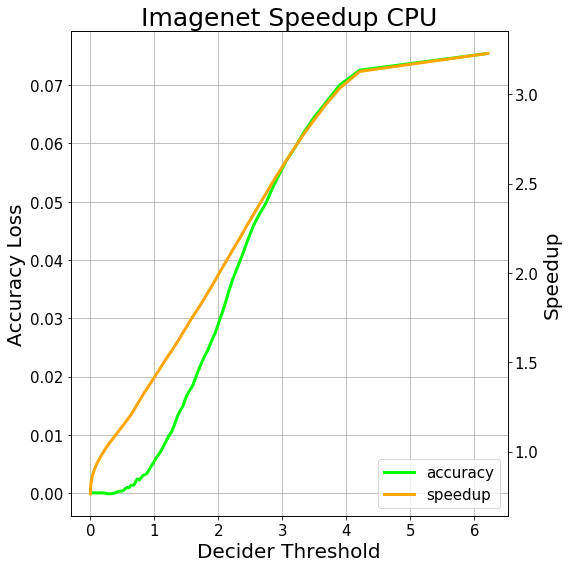

In [129]:
show(t, a2, speedup_cpu2, 'Imagenet Speedup CPU')

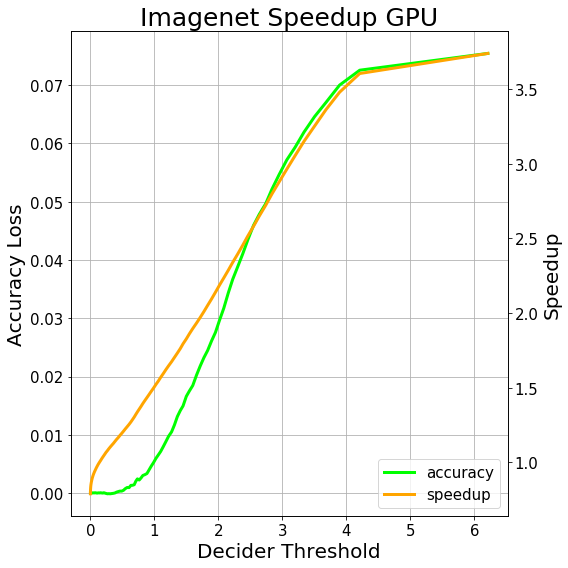

In [130]:
show(t, a2, speedup_gpu2, 'Imagenet Speedup GPU')

In [131]:
def show_auc(y_val, y_pred, entropy_val, auc_entropy, auc_boosting):
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax1.set_xlabel('False Positive Rate', fontsize=20)  
    ax1.set_ylabel('True Positive Rate', fontsize=20)  

    fpr, tpr, threshold = roc_curve(y_val, entropy_val)
    ax1.plot(fpr, tpr, c='lime', label='ROC entropy (area = %0.2f)' % auc_entropy, linewidth=3)

    fpr, tpr, threshold = roc_curve(y_val, y_pred)
    ax1.plot(fpr, tpr, c='orange', label='ROC Boosting (area = %0.2f)' % auc_boosting, linewidth=3)

    ax1.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', linewidth=3)
    ax1.legend(loc=4, fontsize = 15)
    ax1.tick_params(labelsize=15)

    fig.tight_layout() 
    ax1.set_title('ROC Entropy vs ROC Boosting', fontsize=25)
    ax1.grid()
    plt.show()

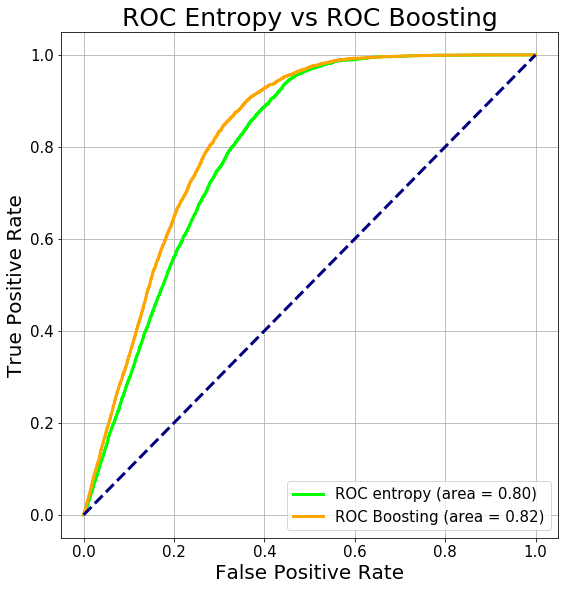

In [132]:
show_auc(y_val, y_pred, entropy_val, auc_entropy, auc_boosting)

In [105]:
acc_loss = [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]

In [107]:
resnets = [18, 34, 50, 101]
for i in range(len(resnets)-1) :
    for j in range(i+1, len(resnets)) :
        net1 = 'resnet_' + str(resnets[i])
        net2 = 'resnet_' + str(resnets[j])
        y_pred, y_val, entropy_val, accuracy1, accuracy2 = evaluate(net1, net2)
        auc_entropy = roc_auc_score(y_val, entropy_val)
        auc_boosting = roc_auc_score(y_val, y_pred)
        print('AUC entropy', auc_entropy, 'AUC boosting', auc_boosting)   
        
        t, a, p, v01, v10 = calculate_speedup(entropy_val, accuracy1, accuracy2)
        t2, a2, p2, v012, v102 = calculate_speedup(y_pred, accuracy1, accuracy2)
        
        time_small = time_inference_cpu[net1]
        time_large = time_inference_cpu[net2]
        speedup_cpu = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p])
        speedup_cpu2 = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p2])
        time_small = time_inference[net1]
        time_large = time_inference[net2]
        speedup_gpu = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p])
        speedup_gpu2 = np.array([time_large/(x*(time_large+time_small)+(1-x)*time_small) for x in p2])

        for x in acc_loss :
            print(x)
            print('boosting')
            idx = np.argmax(speedup_cpu2[a2<=x])
            print('passed', p2[idx])
            print('cpu', speedup_cpu2[idx], a2[idx])
            idx = np.argmax(speedup_gpu2[a2<=x])
            print('gpu', speedup_gpu2[idx], a2[idx])
            print('')
            print('entropy')
            idx = np.argmax(speedup_cpu[a<=x])
            print('passed', p[idx])
            print('cpu', speedup_cpu[idx], a[idx])
            idx = np.argmax(speedup_gpu[a<=x])
            print('gpu', speedup_gpu[idx], a[idx])
        
        print('')
        print('')
    print('===========================================')

resnet_18 0.6972 + resnet_34 0.72984
AUC entropy 0.7762799926806198 AUC boosting 0.8145272218110744
0.0
boosting
passed 0.31284
cpu 1.088935465032506 -0.00023999999999990695
gpu 1.086148295630332 -0.00023999999999990695

entropy
passed 0.46304
cpu 0.9358668541122267 -0.00023999999999990695
gpu 0.933807440901021 -0.00023999999999990695
0.005
boosting
passed 0.2288
cpu 1.1986267577295435 0.0050000000000000044
gpu 1.1952506596199741 0.0050000000000000044

entropy
passed 0.32078
cpu 1.079601074798926 0.0050000000000000044
gpu 1.0768614239007455 0.0050000000000000044
0.01
boosting
passed 0.17308
cpu 1.2844092163557699 0.009979999999999989
gpu 1.2805333712528082 0.009979999999999989

entropy
passed 0.23546
cpu 1.1891340737865495 0.010060000000000069
gpu 1.1858111647183904 0.010060000000000069
0.015
boosting
passed 0.13022
cpu 1.3592347912403433 0.014979999999999993
gpu 1.3548949663152534 0.014979999999999993

entropy
passed 0.18346
cpu 1.267510553143129 0.014960000000000084
gpu 1.26373587439

resnet_50 0.75826 + resnet_101 0.77266
AUC entropy 0.8249929084473577 AUC boosting 0.8559524972474787
0.0
boosting
passed 0.13386
cpu 1.2751319107031776 0.0
gpu 1.3078379189005618 0.0

entropy
passed 0.25634
cpu 1.1028853153983473 2.0000000000020002e-05
gpu 1.1272676851962875 2.0000000000020002e-05
0.005
boosting
passed 0.08276
cpu 1.3640097502508979 0.0049799999999999844
gpu 1.401500953090739 0.0049799999999999844

entropy
passed 0.12036
cpu 1.297466869720091 0.0050200000000000244
gpu 1.3313438759555156 0.0050200000000000244
0.01
boosting
passed 0.03786
cpu 1.4529971634314287 0.009979999999999989
gpu 1.4956161799128382 0.009979999999999989

entropy
passed 0.05418
cpu 1.4193404654530033 0.009979999999999989
gpu 1.4599803145619683 0.009979999999999989
0.015
boosting
passed 0.0
cpu 1.5375801755609826 0.014399999999999968
gpu 1.5853871894236535 0.014399999999999968

entropy
passed 0.0
cpu 1.5375801755609826 0.014399999999999968
gpu 1.5853871894236535 0.014399999999999968
0.02
boosting
pas